In [12]:
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf 
%matplotlib inline

In [18]:
class activation :
    def __init__(self):
        pass
    def do(self, x):
        pass
    def derivative(self, x):
        pass
class sigmoid(activation):
    def do(self, x):
        return 1/(1+np.exp(-x))
    def derivative(self, x):
        return x*(1-x)
class tanh(activation):
    def do(self, x):
        return np.tanh(x)
    def derivative(self, x):
        return 1-x**2
class relu(activation):
    def do(self, x):
        return np.maximum(0,x)
    def derivative(self, x):
        x[x<=0] = 0
        x[x>0] = 1
        return x
class leaky_relu(activation):
    def __init__(self, alpha = 0.01):
        self.alpha = alpha
    def do(self, x):
        return np.maximum(x*self.alpha,x)
    def derivative(self, x):
        x[x<=0] = self.alpha
        x[x>0] = 1
        return x
class LLayer():
    def __init__(self, layers_dim, activations, learning_rate=0.1, lambd = 0):
        self.parameters = {}
        self.A = {}
        self.grads = {}
        self.losses = []
        self.accuracies = []
        self.val_losses = []
        self.val_accuracies = []
        self.activations = activations
        self.lr = learning_rate
        self.layer_dims = layers_dim
        self.L = len(self.layer_dims)
        self.lambd = lambd
        
    def initialize_parameters_deep(self):
        for i in range(1, self.L-1):
            self.parameters['W'+str(i)] = np.random.normal(0,1,(self.layer_dims[i-1], self.layer_dims[i])) 
            self.parameters['b'+str(i)] = np.zeros(self.layer_dims[i])
        self.parameters['W'+str(self.L-1)] = np.random.normal(0, 1, (self.layer_dims[self.L-2] , 1)) 
        self.parameters['b'+str(self.L-1)] = 0
            
    def forpass(self, x):
        z = np.dot(x, self.parameters['W1']) + self.parameters['b1']
        self.A['A1'] = self.activations[0].do(z)
        
        for i in range(2, self.L):
            z = np.dot(self.A['A'+str(i-1)], self.parameters['W'+str(i)]) + self.parameters['b'+str(i)]
            self.A['A'+str(i)] = self.activations[i-1].do(z)
        
        return self.A['A'+str(self.L-1)]

    def backprop(self, x, err):
        m = len(x)
        
        self.grads['dW'+str(self.L - 1)] = np.dot(self.A['A'+str(self.L - 2)].T, err) / m
        self.grads['db'+str(self.L - 1)] = np.sum(err) / m
        err_hidden = np.dot(err, self.parameters['W'+str(self.L - 1)].T) * self.activations[self.L-3].derivative(self.A['A'+str(self.L - 2)])
        
        for l in reversed(range(2, self.L-1)): 
            self.grads['dW'+str(l)] = np.dot(self.A['A'+str(l-1)].T, err_hidden) / m
            self.grads['db'+str(l)] = np.sum(err_hidden, axis=0) / m
            err_hidden = np.dot(err_hidden, self.parameters['W'+str(l)].T) * self.activations[l-2].derivative(self.A['A'+str(l - 1)])
        
        self.grads['dW1'] = np.dot(x.T, err_hidden) / m
        self.grads['db1'] = np.sum(err_hidden, axis=0) / m
        
        
        
            
    def parameters_update(self, x):
        m = len(x)
        for i in range(1, self.L):
            s_i = str(i)
            self.grads['dW'+s_i] += (self.lambd * self.parameters['W'+s_i]) / m
            self.parameters['W'+s_i] -= self.lr * self.grads['dW'+s_i]
            self.parameters['b'+s_i] -= self.lr * self.grads['db'+s_i]
    

    def training(self, X, Y):
        a = self.forpass(X)
        err = -(Y-a) # compute err
        self.backprop(X, err)
        self.parameters_update(X)
        
        return a
    
    def fit(self, x, y, epochs=100, x_val=None, y_val=None):
        np.random.seed(42)
        self.initialize_parameters_deep()
        print('*'*int(epochs/200))
        for i in range(epochs):
            if(i % 200 == 0) :
                print('*', end='')
            a = self.training(x, y)
            a = np.clip(a, 1e-10, 1-1e-10)
            cost = np.sum(-(y*np.log(a) + (1-y)*np.log(1-a)))
            self.losses.append(cost / len(x))
            self.accuracies.append(self.score(x,y))
            self.update_val_loss(x_val, y_val)
            self.val_accuracies.append(self.score(x_val, y_val))
    
    def drawPlot(self, value):
        if(value == 'cost'):
            plt.plot(np.squeeze(self.losses), label='train set')
            plt.plot(np.squeeze(self.val_losses), label='validation')
        elif(value == 'accuracies'):
            plt.plot(self.accuracies, label='train set')
            plt.plot(np.squeeze(self.val_accuracies), label='validation')
            
        plt.ylabel(value)
        plt.xlabel('iterations ')
        plt.legend()
        plt.title("Learning rate =" + str(self.lr))
        plt.show()
        
    
    def predict(self,x):
        z = [self.forpass(x_i) for x_i in x]
        return np.array(z) > 0.5
    
    def score(self, x,y):
        return np.mean(self.predict(x) == y.reshape(-1, 1))
    
    def cost(self,AL, Y):
        m = Y.shape[0]
        cost = np.sum(Y * np.log(AL) + (1-Y)* np.log(1-AL)) / -len(Y)
        cost = np.squeeze(cost)
        
        return cost
    
    def update_val_loss(self, x_val, y_val):
        a = self.forpass(x_val)
        a = np.clip(a, 1e-10, 1-1e-10)
        cost = np.sum(-(y_val*np.log(a) + (1-y_val)*np.log(1-a)))
        self.val_losses.append((cost)/len(y_val))
            
            
        

In [5]:
transform = transforms.Compose([#transforms.Resize((256,256)),  
                                transforms.Grayscale(),		# the code transforms.Graysclae() is for changing the size [3,100,100] to [1, 100, 100] (notice : [channel, height, width] )
                                transforms.ToTensor(),])


#train_data_path = 'relative path of training data set'
train_data_path = '../horse-or-human/train'
trainset = torchvision.datasets.ImageFolder(root=train_data_path, transform=transform)
# change the valuse of batch_size, num_workers for your program
# if shuffle=True, the data reshuffled at every epoch 
trainloader = torch.utils.data.DataLoader(trainset, batch_size=1, shuffle=False, num_workers=1)  


validation_data_path = '../horse-or-human/validation'
valset = torchvision.datasets.ImageFolder(root=validation_data_path, transform=transform)
# change the valuse of batch_size, num_workers for your program
valloader = torch.utils.data.DataLoader(valset, batch_size=1, shuffle=False, num_workers=1)  

train_x = []
train_y = []
test_x = []
test_y = []
for i, data in enumerate(trainloader):
    # inputs is the image
    # labels is the class of the image
    
    
    inputs, labels = data
    #change tensor to numpy array
    train_y.append(labels.numpy()[0])
    train_x.append(torch.reshape(inputs, (10000,1)).numpy())
    


# load validation images of the batch size for every iteration
for i, data in enumerate(valloader):
    # inputs is the image
    # labels is the class of the image
    inputs, labels = data
    #change tensor to numpy array
    test_y.append(labels.numpy()[0])
    test_x.append(torch.reshape(inputs, (10000,)).numpy())
    
def listToNP(v_list):
    return np.squeeze(np.asarray(v_list))

#list that contains numpy array convert to numpy array 
train_x = np.transpose(listToNP(train_x)).T
train_y = listToNP(train_y).reshape((1,1027)).T
test_x = np.transpose(listToNP(test_x)).T
test_y = listToNP(test_y).reshape((1,256)).T

In [10]:
#define layers
layers_dim = [10000, 20, 10, 1]

activations = []

#activation function = tanh()
for i in range(len(layers_dim)-2):
    activations.append(sigmoid())
activations.append(sigmoid())

temp_layer = LLayer(layers_dim, activations,learning_rate=0.05, lambd = 0.1)
start_time = time.time()
temp_layer.fit(train_x, train_y, epochs=500, x_val=test_x, y_val=test_y)
end_time = time.time()
print('')
print(end_time - start_time)

**
***
103.3537905216217


## apply norm 2 with lambda = 0.1

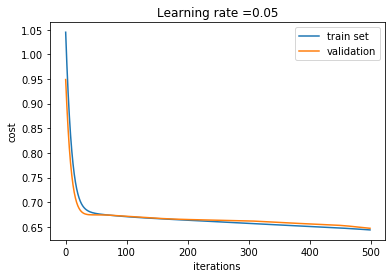

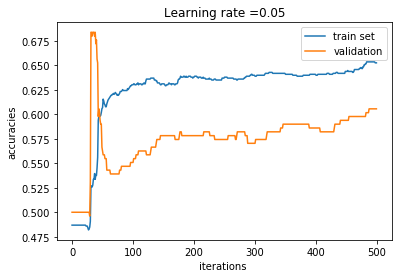

********** the result of activation sigmoid function ***************
last accuracy of train      : 0.6523855890944499
last accuracy of validation : 0.60546875
last loss of train          : 0.6436046413134073
last loss of validation     : 0.6468938774116965


In [11]:
temp_layer.drawPlot('cost')
temp_layer.drawPlot('accuracies')
print('********** the result of activation sigmoid function ***************')
print('last accuracy of train      : ' + str(temp_layer.accuracies[-1]))
print('last accuracy of validation : ' + str(temp_layer.val_accuracies[-1]))
print('last loss of train          : ' + str(temp_layer.losses[-1]))
print('last loss of validation     : ' + str(temp_layer.val_losses[-1]))

In [13]:
#define layers
layers_dim = [10000, 20, 10, 1]

activations = []

#activation function = tanh()
for i in range(len(layers_dim)-2):
    activations.append(sigmoid())
activations.append(sigmoid())

temp_layer = LLayer(layers_dim, activations,learning_rate=0.05, lambd = 0.1)
start_time = time.time()
temp_layer.fit(train_x, train_y, epochs=2000, x_val=test_x, y_val=test_y)
end_time = time.time()
print('')
print(end_time - start_time)

**********
**********
415.5706989765167


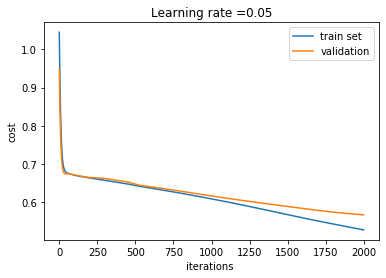

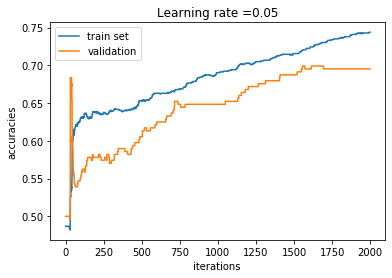

********** the result of activation sigmoid function ***************
last accuracy of train      : 0.7439143135345667
last accuracy of validation : 0.6953125
last loss of train          : 0.5272281666368777
last loss of validation     : 0.5667903067744637


In [14]:
temp_layer.drawPlot('cost')
temp_layer.drawPlot('accuracies')
print('********** the result of activation sigmoid function ***************')
print('last accuracy of train      : ' + str(temp_layer.accuracies[-1]))
print('last accuracy of validation : ' + str(temp_layer.val_accuracies[-1]))
print('last loss of train          : ' + str(temp_layer.losses[-1]))
print('last loss of validation     : ' + str(temp_layer.val_losses[-1]))

********************
********************
835.667585849762


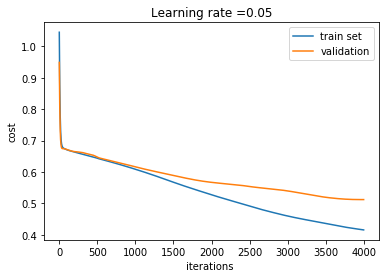

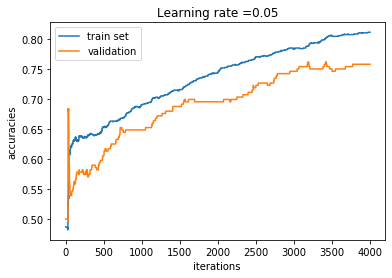

********** the result of activation sigmoid function ***************
last accuracy of train      : 0.8111002921129503
last accuracy of validation : 0.7578125
last loss of train          : 0.4152428703885068
last loss of validation     : 0.5118810545466436


In [19]:
#define layers
layers_dim = [10000, 20, 10, 1]

activations = []

#activation function = tanh()
for i in range(len(layers_dim)-2):
    activations.append(sigmoid())
activations.append(sigmoid())

temp_layer = LLayer(layers_dim, activations,learning_rate=0.05, lambd = 0.1)
start_time = time.time()
temp_layer.fit(train_x, train_y, epochs=4000, x_val=test_x, y_val=test_y)
end_time = time.time()
print('')
print(end_time - start_time)
temp_layer.drawPlot('cost')
temp_layer.drawPlot('accuracies')
print('********** the result of activation sigmoid function ***************')
print('last accuracy of train      : ' + str(temp_layer.accuracies[-1]))
print('last accuracy of validation : ' + str(temp_layer.val_accuracies[-1]))
print('last loss of train          : ' + str(temp_layer.losses[-1]))
print('last loss of validation     : ' + str(temp_layer.val_losses[-1]))

*************************
*************************
1032.8680272102356


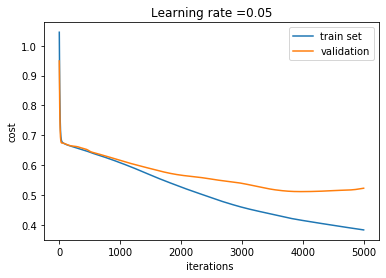

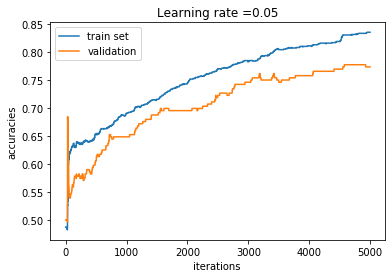

********** the result of activation sigmoid function ***************
last accuracy of train      : 0.8354430379746836
last accuracy of validation : 0.7734375
last loss of train          : 0.383689478941464
last loss of validation     : 0.5231423699846379


In [20]:
#define layers
layers_dim = [10000, 20, 10, 1]

activations = []

#activation function = tanh()
for i in range(len(layers_dim)-2):
    activations.append(sigmoid())
activations.append(sigmoid())

temp_layer = LLayer(layers_dim, activations,learning_rate=0.05, lambd = 0.1)
start_time = time.time()
temp_layer.fit(train_x, train_y, epochs=5000, x_val=test_x, y_val=test_y)
end_time = time.time()
print('')
print(end_time - start_time)
temp_layer.drawPlot('cost')
temp_layer.drawPlot('accuracies')
print('********** the result of activation sigmoid function ***************')
print('last accuracy of train      : ' + str(temp_layer.accuracies[-1]))
print('last accuracy of validation : ' + str(temp_layer.val_accuracies[-1]))
print('last loss of train          : ' + str(temp_layer.losses[-1]))
print('last loss of validation     : ' + str(temp_layer.val_losses[-1]))

*************************
*************************
1035.6836230754852


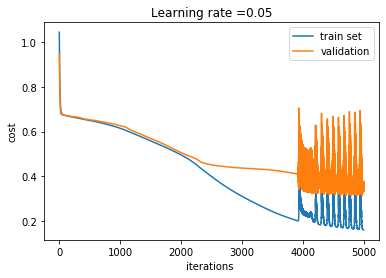

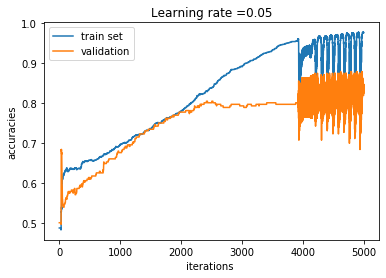

********** the result of activation sigmoid function ***************
last accuracy of train      : 0.9766309639727361
last accuracy of validation : 0.8203125
last loss of train          : 0.15930881648599363
last loss of validation     : 0.3765895907040353


In [21]:
#define layers
layers_dim = [10000, 20, 10, 1]

activations = []

#activation function = tanh()
for i in range(len(layers_dim)-2):
    activations.append(sigmoid())
activations.append(sigmoid())

temp_layer = LLayer(layers_dim, activations,learning_rate=0.05, lambd = 10)
start_time = time.time()
temp_layer.fit(train_x, train_y, epochs=5000, x_val=test_x, y_val=test_y)
end_time = time.time()
print('')
print(end_time - start_time)
temp_layer.drawPlot('cost')
temp_layer.drawPlot('accuracies')
print('********** the result of activation sigmoid function ***************')
print('last accuracy of train      : ' + str(temp_layer.accuracies[-1]))
print('last accuracy of validation : ' + str(temp_layer.val_accuracies[-1]))
print('last loss of train          : ' + str(temp_layer.losses[-1]))
print('last loss of validation     : ' + str(temp_layer.val_losses[-1]))

******************
******************
742.0799367427826


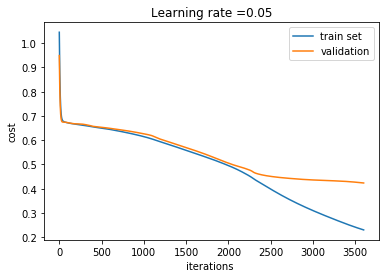

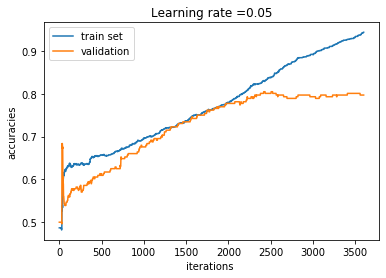

********** the result of activation sigmoid function ***************
last accuracy of train      : 0.943524829600779
last accuracy of validation : 0.796875
last loss of train          : 0.23026723962602014
last loss of validation     : 0.423677792264893


In [22]:
#define layers
layers_dim = [10000, 20, 10, 1]

activations = []

#activation function = tanh()
for i in range(len(layers_dim)-2):
    activations.append(sigmoid())
activations.append(sigmoid())

temp_layer = LLayer(layers_dim, activations,learning_rate=0.05, lambd = 10)
start_time = time.time()
temp_layer.fit(train_x, train_y, epochs=3600, x_val=test_x, y_val=test_y)
end_time = time.time()
print('')
print(end_time - start_time)
temp_layer.drawPlot('cost')
temp_layer.drawPlot('accuracies')
print('********** the result of activation sigmoid function ***************')
print('last accuracy of train      : ' + str(temp_layer.accuracies[-1]))
print('last accuracy of validation : ' + str(temp_layer.val_accuracies[-1]))
print('last loss of train          : ' + str(temp_layer.losses[-1]))
print('last loss of validation     : ' + str(temp_layer.val_losses[-1]))

*************************
*************************
1038.5580921173096


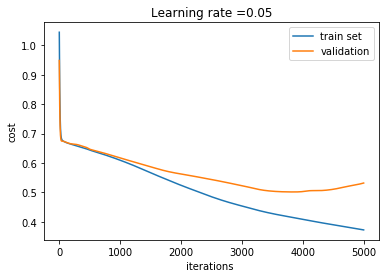

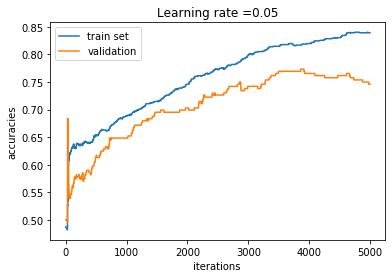

********** the result of activation sigmoid function ***************
last accuracy of train      : 0.8393378773125608
last accuracy of validation : 0.74609375
last loss of train          : 0.3721272731673473
last loss of validation     : 0.5317204981091203


In [23]:
#define layers
layers_dim = [10000, 20, 10, 1]

activations = []

#activation function = tanh()
for i in range(len(layers_dim)-2):
    activations.append(sigmoid())
activations.append(sigmoid())

temp_layer = LLayer(layers_dim, activations,learning_rate=0.05, lambd = 1)
start_time = time.time()
temp_layer.fit(train_x, train_y, epochs=5000, x_val=test_x, y_val=test_y)
end_time = time.time()
print('')
print(end_time - start_time)
temp_layer.drawPlot('cost')
temp_layer.drawPlot('accuracies')
print('********** the result of activation sigmoid function ***************')
print('last accuracy of train      : ' + str(temp_layer.accuracies[-1]))
print('last accuracy of validation : ' + str(temp_layer.val_accuracies[-1]))
print('last loss of train          : ' + str(temp_layer.losses[-1]))
print('last loss of validation     : ' + str(temp_layer.val_losses[-1]))

********************
********************
836.9564361572266


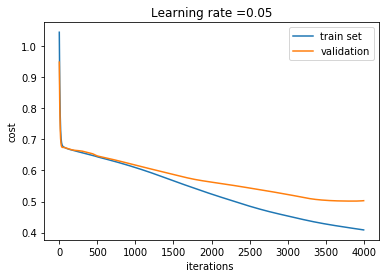

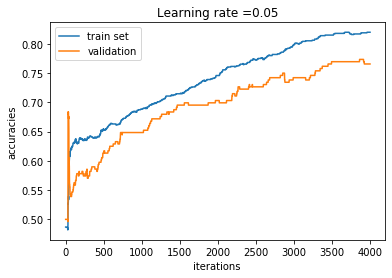

********** the result of activation sigmoid function ***************
last accuracy of train      : 0.8198636806231743
last accuracy of validation : 0.765625
last loss of train          : 0.40858074245137255
last loss of validation     : 0.5026938694024609


In [24]:
#define layers
layers_dim = [10000, 20, 10, 1]

activations = []

#activation function = tanh()
for i in range(len(layers_dim)-2):
    activations.append(sigmoid())
activations.append(sigmoid())

temp_layer = LLayer(layers_dim, activations,learning_rate=0.05, lambd = 1)
start_time = time.time()
temp_layer.fit(train_x, train_y, epochs=4000, x_val=test_x, y_val=test_y)
end_time = time.time()
print('')
print(end_time - start_time)
temp_layer.drawPlot('cost')
temp_layer.drawPlot('accuracies')
print('********** the result of activation sigmoid function ***************')
print('last accuracy of train      : ' + str(temp_layer.accuracies[-1]))
print('last accuracy of validation : ' + str(temp_layer.val_accuracies[-1]))
print('last loss of train          : ' + str(temp_layer.losses[-1]))
print('last loss of validation     : ' + str(temp_layer.val_losses[-1]))

********************
********************
839.3633179664612


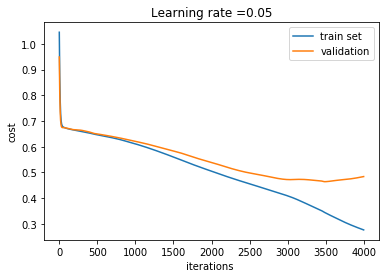

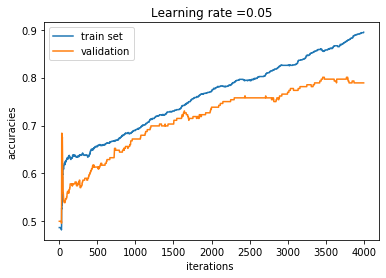

********** the result of activation sigmoid function ***************
last accuracy of train      : 0.8948393378773125
last accuracy of validation : 0.7890625
last loss of train          : 0.27676240017427345
last loss of validation     : 0.48409444789556244


In [25]:
#define layers
layers_dim = [10000, 20, 10, 1]

activations = []

#activation function = tanh()
for i in range(len(layers_dim)-2):
    activations.append(sigmoid())
activations.append(sigmoid())

temp_layer = LLayer(layers_dim, activations,learning_rate=0.05, lambd = 5)
start_time = time.time()
temp_layer.fit(train_x, train_y, epochs=4000, x_val=test_x, y_val=test_y)
end_time = time.time()
print('')
print(end_time - start_time)
temp_layer.drawPlot('cost')
temp_layer.drawPlot('accuracies')
print('********** the result of activation sigmoid function ***************')
print('last accuracy of train      : ' + str(temp_layer.accuracies[-1]))
print('last accuracy of validation : ' + str(temp_layer.val_accuracies[-1]))
print('last loss of train          : ' + str(temp_layer.losses[-1]))
print('last loss of validation     : ' + str(temp_layer.val_losses[-1]))

## 3-nn model best accuracy(sigmoid with regularization term based on L2 norm)

Bias (large λ = 10)

| dataset | loss | accuracy | 
|:-------|-------:|:------:|
|   training    |0.230267239626|0.9435248296|
|   validation    |0.423677792264|0.796875|


Variance (small λ = 0.1)

| dataset | loss | accuracy | 
|:-------|-------:|:------:|
|   training    |0.3836894789|0.83544303797|
|   validation    |0.523142369|0.7734375|



Best Generalization (appropriate λ = 10)

| dataset | loss | accuracy | 
|:-------|-------:|:------:|
|   training    |0.230267239626|0.9435248296|
|   validation    |0.423677792264|0.796875|


